No cosmic rays detected in Spectrum_1: 870 points
No cosmic rays detected in Spectrum_2: 416 points
Cosmic rays detected in Spectrum_3: 634 points
No cosmic rays detected in Spectrum_4: 310 points
Cosmic rays detected in Spectrum_5: 228 points
  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  20.214781
1  Spectrum_1   -0.998045  Full_Spectrum  20.282387
2  Spectrum_1   -0.996090  Full_Spectrum  20.515862
3  Spectrum_1   -0.994135  Full_Spectrum  20.505255
4  Spectrum_1   -0.992180  Full_Spectrum  20.602119


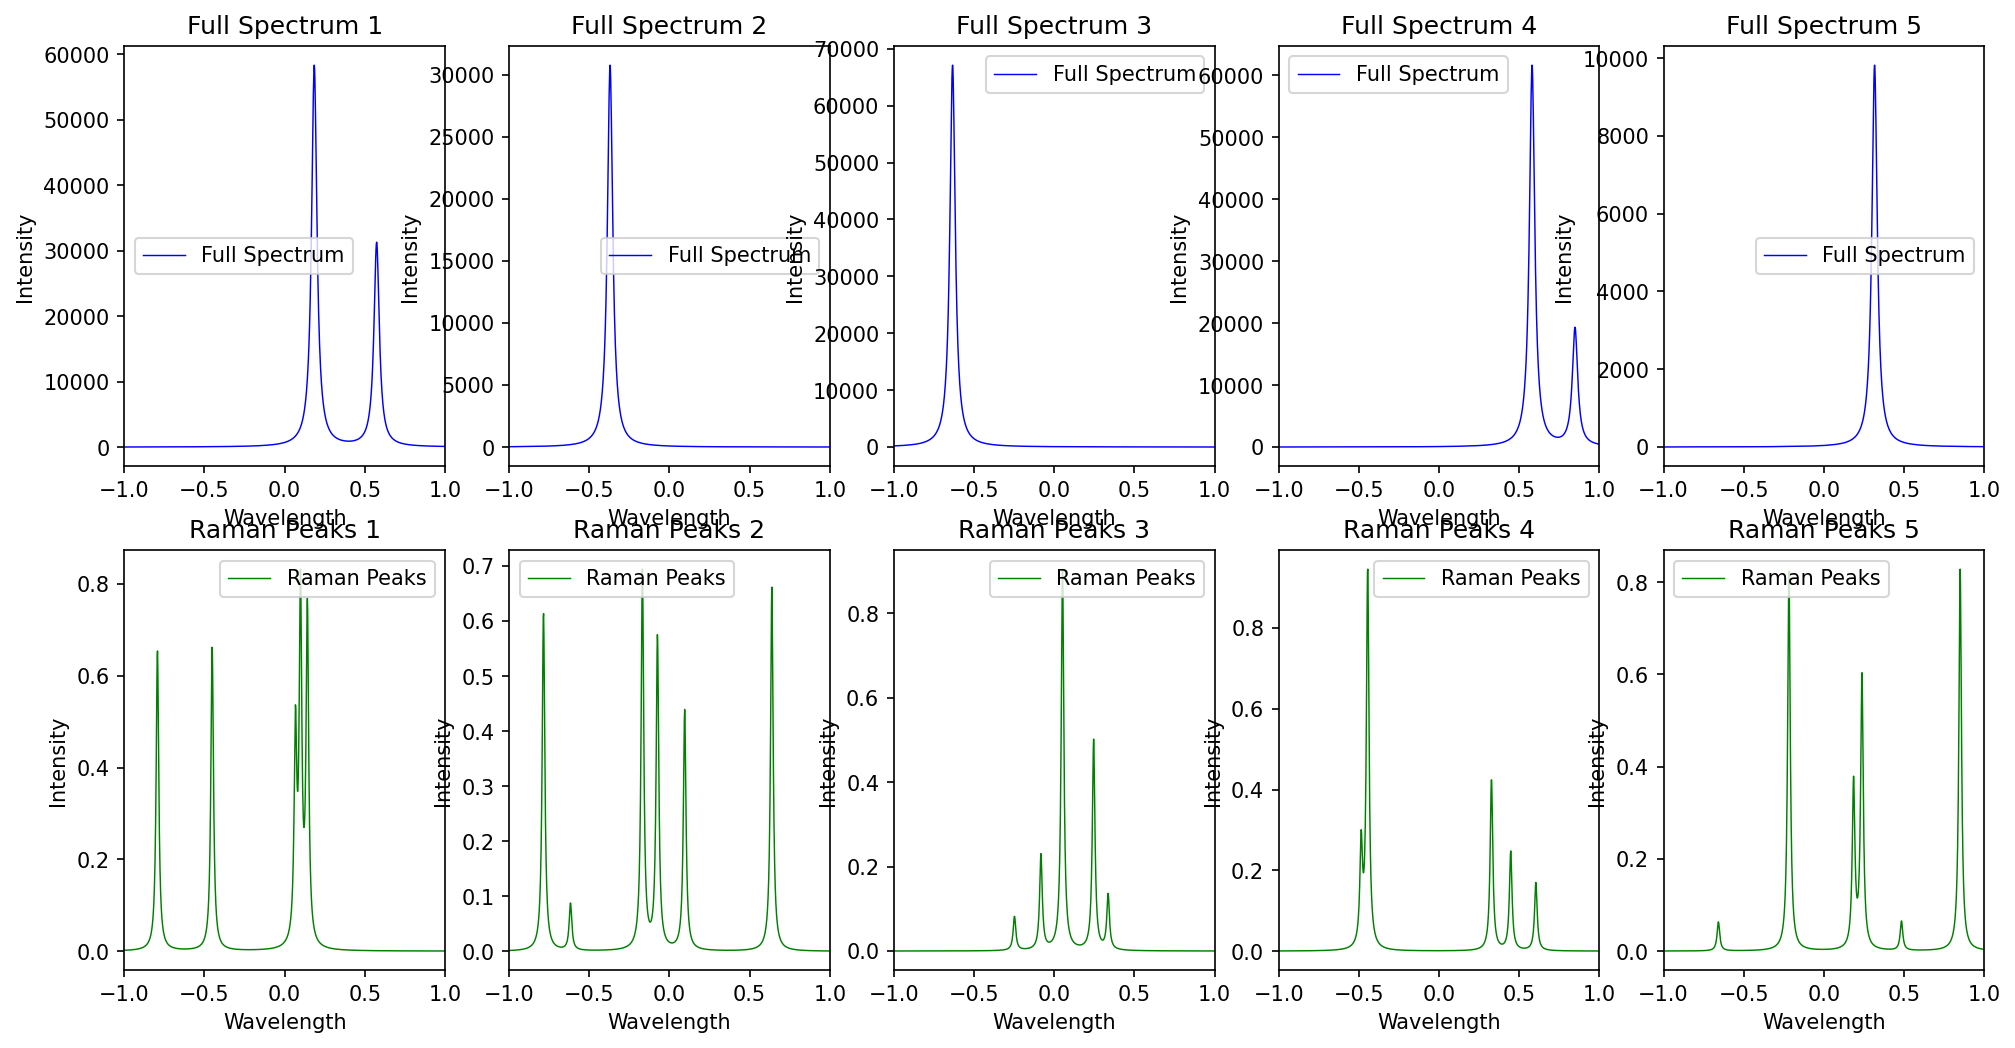

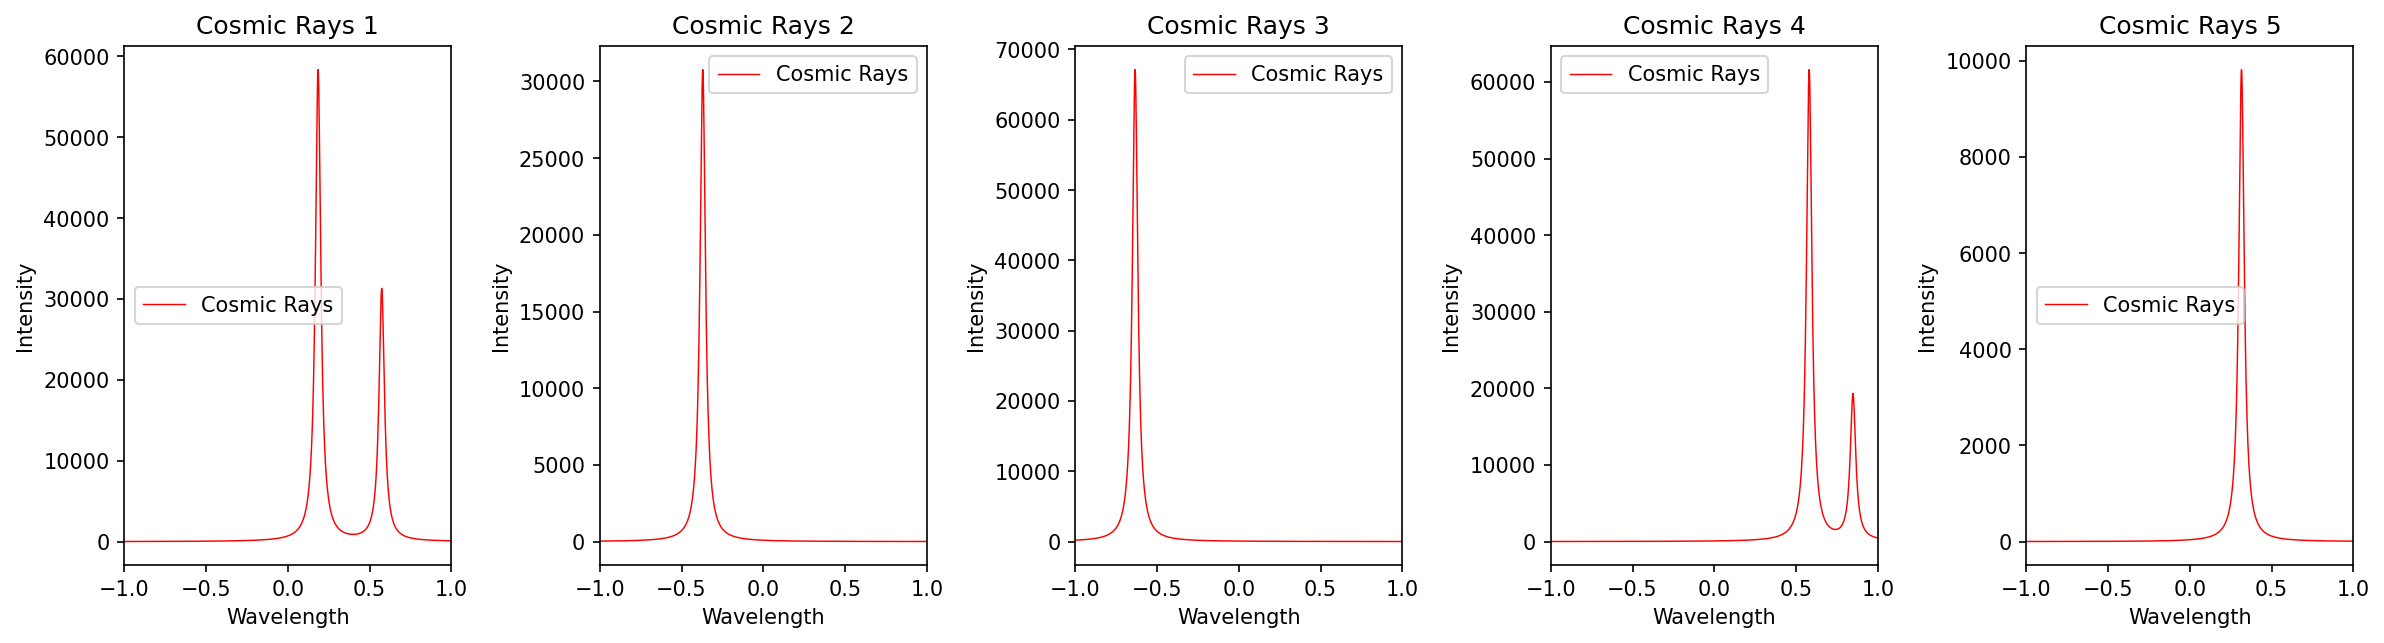

In [1]:
# SYNTHETIC SPECTRA 'ADDING CORRECTLY COSMIC RAYS'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []
        self.cosmic_rays_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self):
        cosmic_rays_spectrum = np.zeros_like(self.wavelengths)

        # Generate a random number of cosmic rays between 1 and 3
        num_cosmic_rays = np.random.randint(1, 4)

        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, np.linalg.norm(self.noisy_peaky_cheby))

            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))

            # Create cosmic ray using Lorentzian peak
            width_factor = 0.02
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2 + width_factor ** 2)

            
            # Add cosmic ray to separate array
            cosmic_rays_spectrum += cosmic_ray
            
        # Add rays to noise peaky cheby spectra
        self.noisy_peaky_cheby_rays = self.noisy_peaky_cheby + cosmic_rays_spectrum

        # Update Full Synthetic Spectrum
        full_spectrum = self.noisy_peaky_cheby_rays
        self.full_spectra_list.append(full_spectrum)

        # Update Raman Spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

        # Update Cosmic Rays
        self.cosmic_rays_list.append(cosmic_rays_spectrum)
        
         # Print information about detected cosmic rays
        cosmic_ray_indices = np.where(self.noisy_peaky_cheby > 0)[0]
        spectrum_id = f'Spectrum_{len(self.full_spectra_list)}'

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum, cosmic_rays) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list, self.cosmic_rays_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, cosmic_rays)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Cosmic_Rays',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df
    
# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    synthetic_data_generator.add_cosmic_rays()

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Plot high resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot original spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', linewidth=0.7, label='Full Spectrum')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
    
# Plot Raman peaks
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7, label='Raman Peaks')
    plt.title(f'Raman Peaks {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()

# Plot cosmic rays only
plt.figure(figsize=(16, 8), dpi=150)
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.cosmic_rays_list[i], color='red', linewidth=0.7, label='Cosmic Rays')
    plt.title(f'Cosmic Rays {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
     
# Show plots
plt.tight_layout()
plt.show()

No cosmic rays detected in Spectrum_1: 417 points
Cosmic rays detected in Spectrum_2: 527 points
No cosmic rays detected in Spectrum_3: 412 points
No cosmic rays detected in Spectrum_4: 1011 points
No cosmic rays detected in Spectrum_5: 991 points
  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  -1.373911
1  Spectrum_1   -0.998045  Full_Spectrum  -1.199263
2  Spectrum_1   -0.996090  Full_Spectrum  -1.202591
3  Spectrum_1   -0.994135  Full_Spectrum  -1.181545
4  Spectrum_1   -0.992180  Full_Spectrum  -1.079508


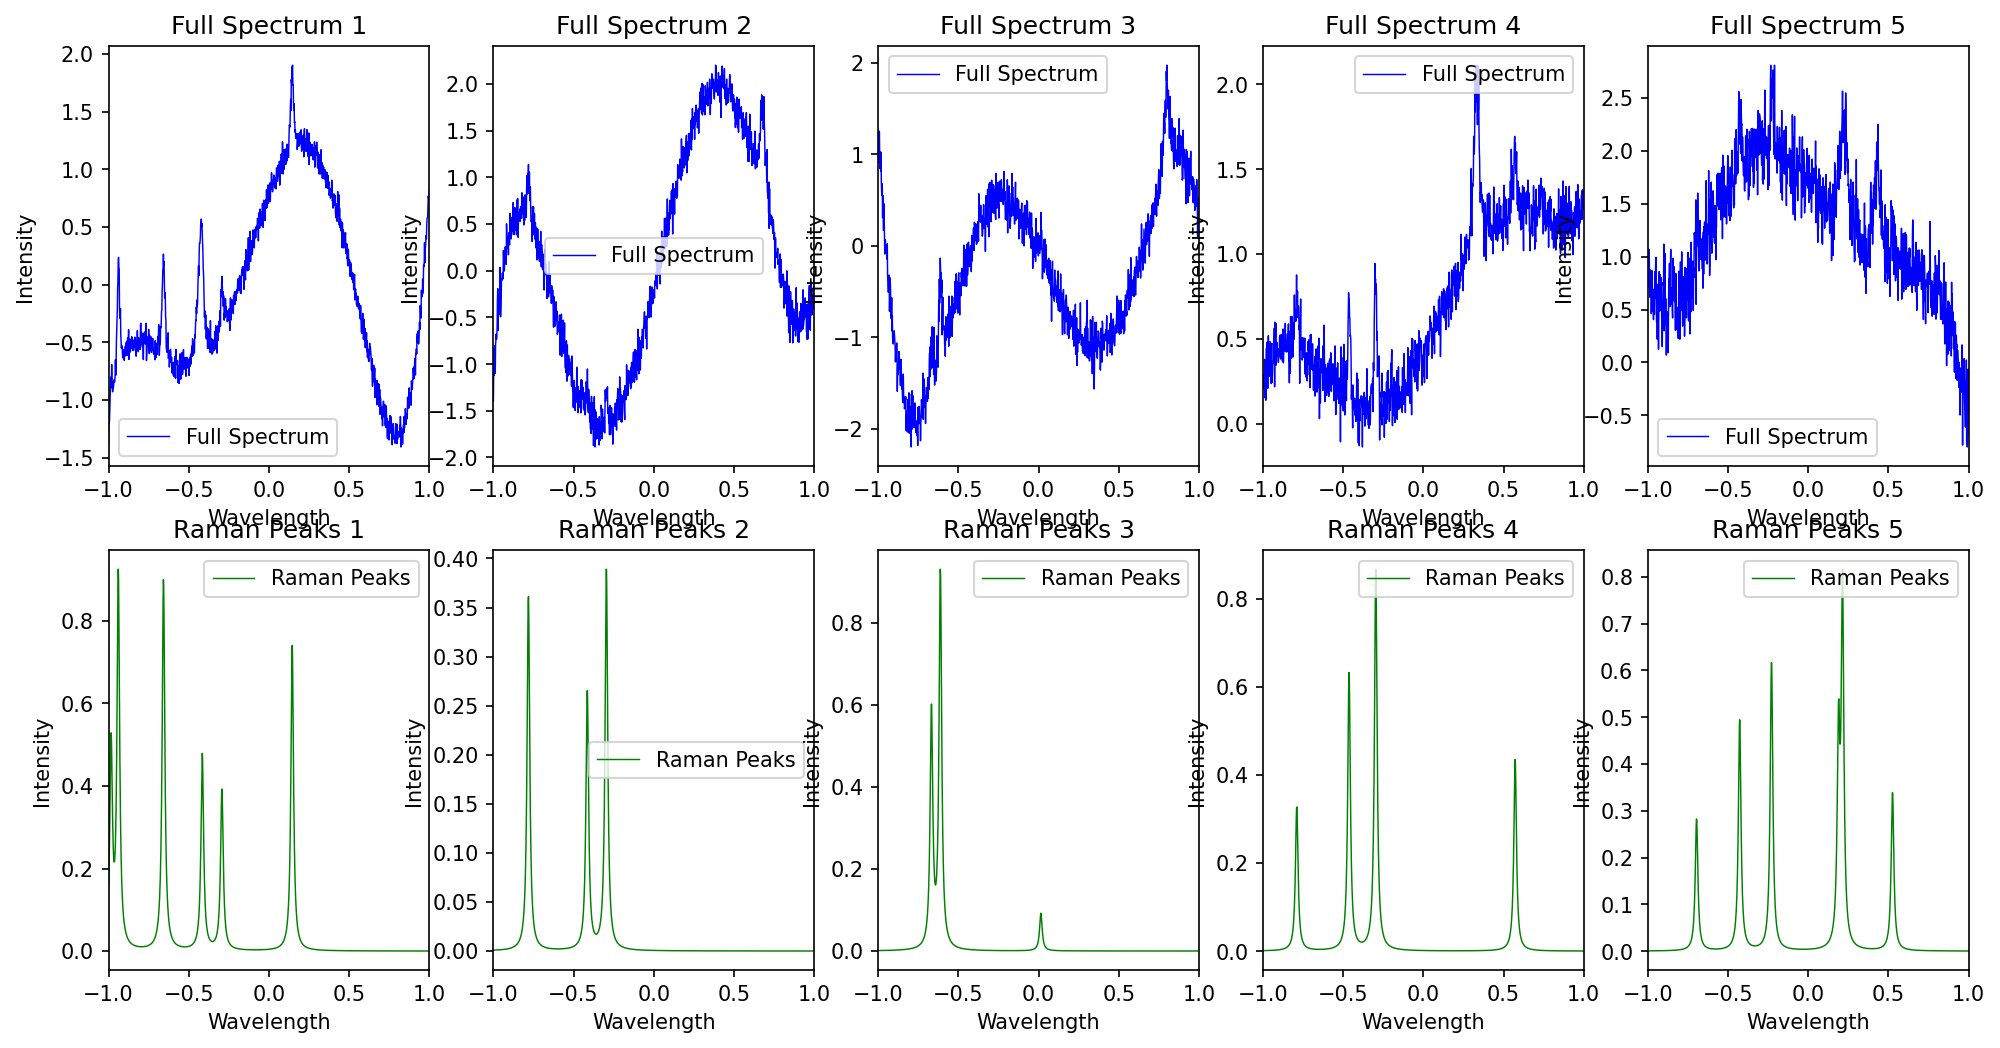

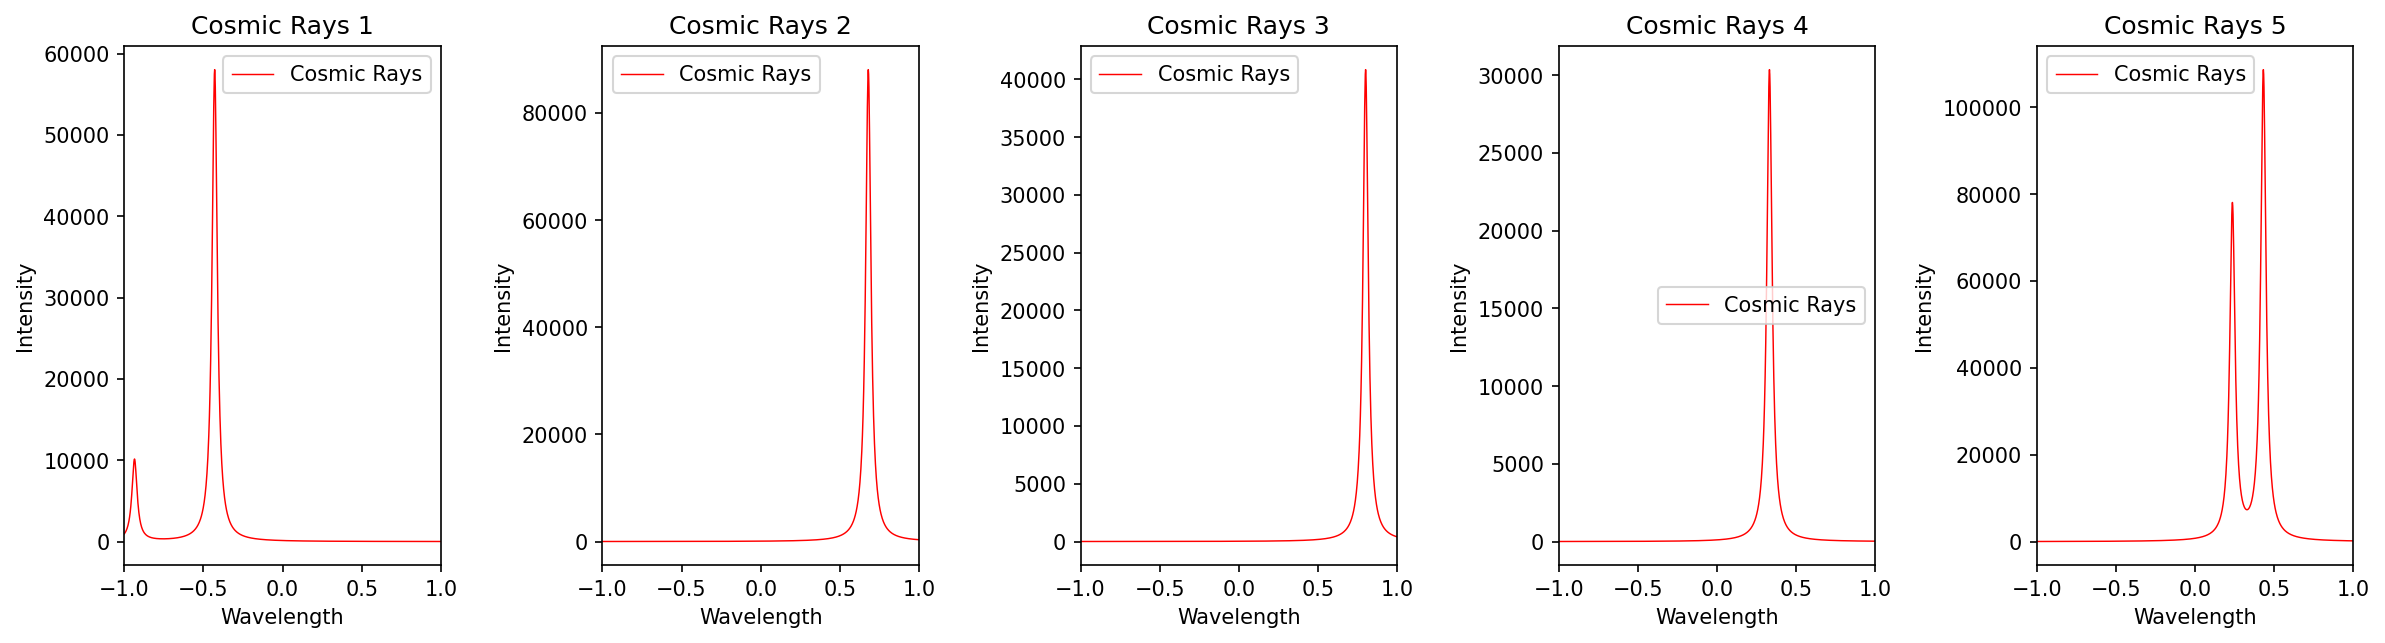

In [2]:
# SYNTHETIC SPECTRA 'ADDING CORRECTLY COSMIC RAYS'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []
        self.cosmic_rays_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self):
        cosmic_rays_spectrum = np.zeros_like(self.wavelengths)

        # Generate a random number of cosmic rays between 1 and 3
        num_cosmic_rays = np.random.randint(1, 4)

        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, np.linalg.norm(self.noisy_peaky_cheby))

            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))

            # Create cosmic ray using Lorentzian peak
            width_factor = 0.02
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2 + width_factor ** 2)

            # Add cosmic ray to separate array
            cosmic_rays_spectrum += cosmic_ray

        # Normalize the entire spectrum (including cosmic rays)
        cosmic_rays_spectrum_norm = cosmic_rays_spectrum / cosmic_rays_spectrum.max()

        # Add rays to noise peaky cheby spectra
        self.noisy_peaky_cheby_rays = self.noisy_peaky_cheby + cosmic_rays_spectrum_norm

        # Update Full Synthetic Spectrum
        full_spectrum = self.noisy_peaky_cheby_rays
        self.full_spectra_list.append(full_spectrum)

        # Update Raman Spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

        # Update Cosmic Rays
        self.cosmic_rays_list.append(cosmic_rays_spectrum)

        # Print information about detected cosmic rays
        spectrum_id = f'Spectrum_{len(self.full_spectra_list)}'
        cosmic_ray_indices = np.where(self.noisy_peaky_cheby_rays > 0)[0]

        # Check if cosmic_ray_indices is not empty & if indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum, cosmic_rays) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list, self.cosmic_rays_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, cosmic_rays)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Cosmic_Rays',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)
    
        return df
    
# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    synthetic_data_generator.add_cosmic_rays()

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Plot high resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot original spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', linewidth=0.7, label='Full Spectrum')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
    
# Plot Raman peaks
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7, label='Raman Peaks')
    plt.title(f'Raman Peaks {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()

# Plot cosmic rays only
plt.figure(figsize=(16, 8), dpi=150)
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.cosmic_rays_list[i], color='red', linewidth=0.7, label='Cosmic Rays')
    plt.title(f'Cosmic Rays {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
     
# Show plots
plt.tight_layout()
plt.show()

No cosmic rays detected in Spectrum_1: 0 points
No cosmic rays detected in Spectrum_2: 0 points
No cosmic rays detected in Spectrum_3: 0 points
No cosmic rays detected in Spectrum_4: 0 points
No cosmic rays detected in Spectrum_5: 0 points


/tmp/ipykernel_18/2076631033.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrum_data['Intensity'] /= spectrum_data['Intensity'].max()


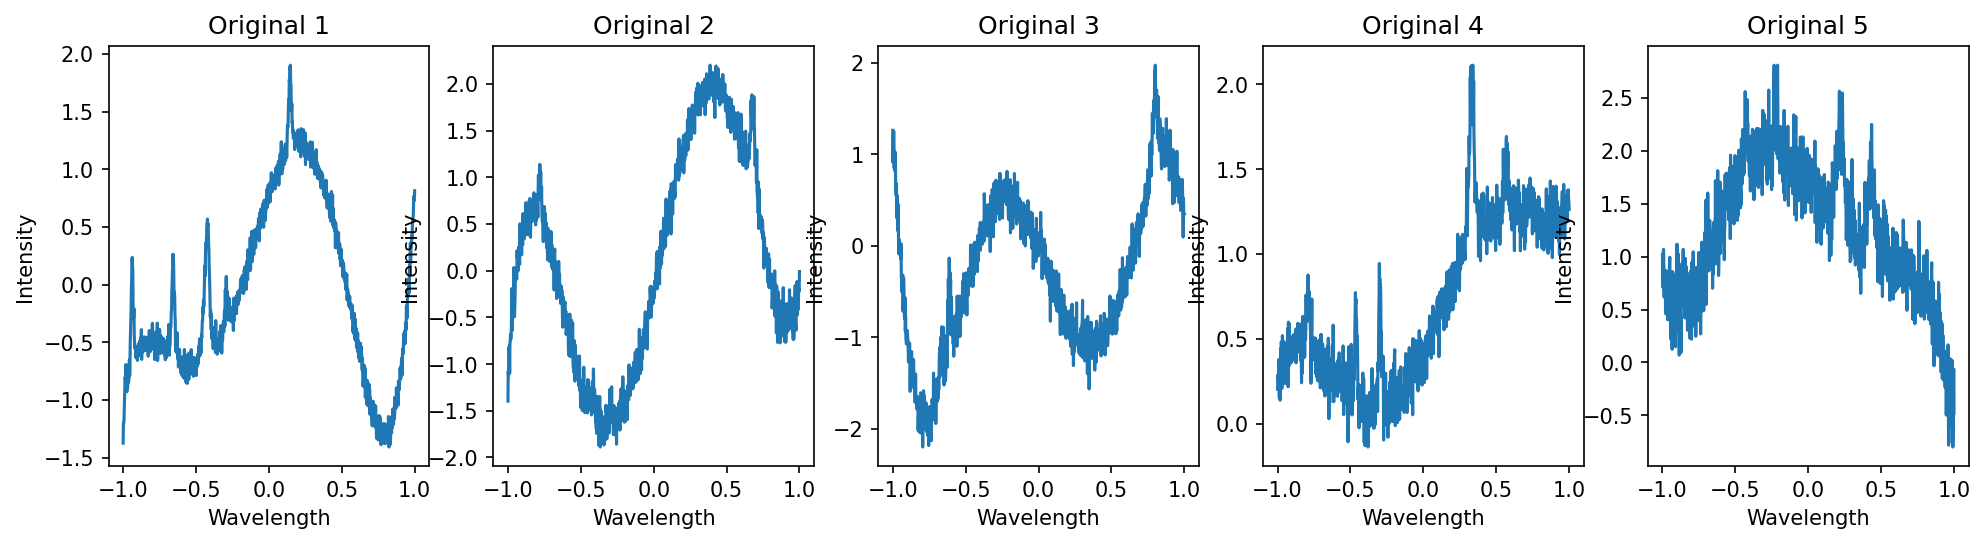

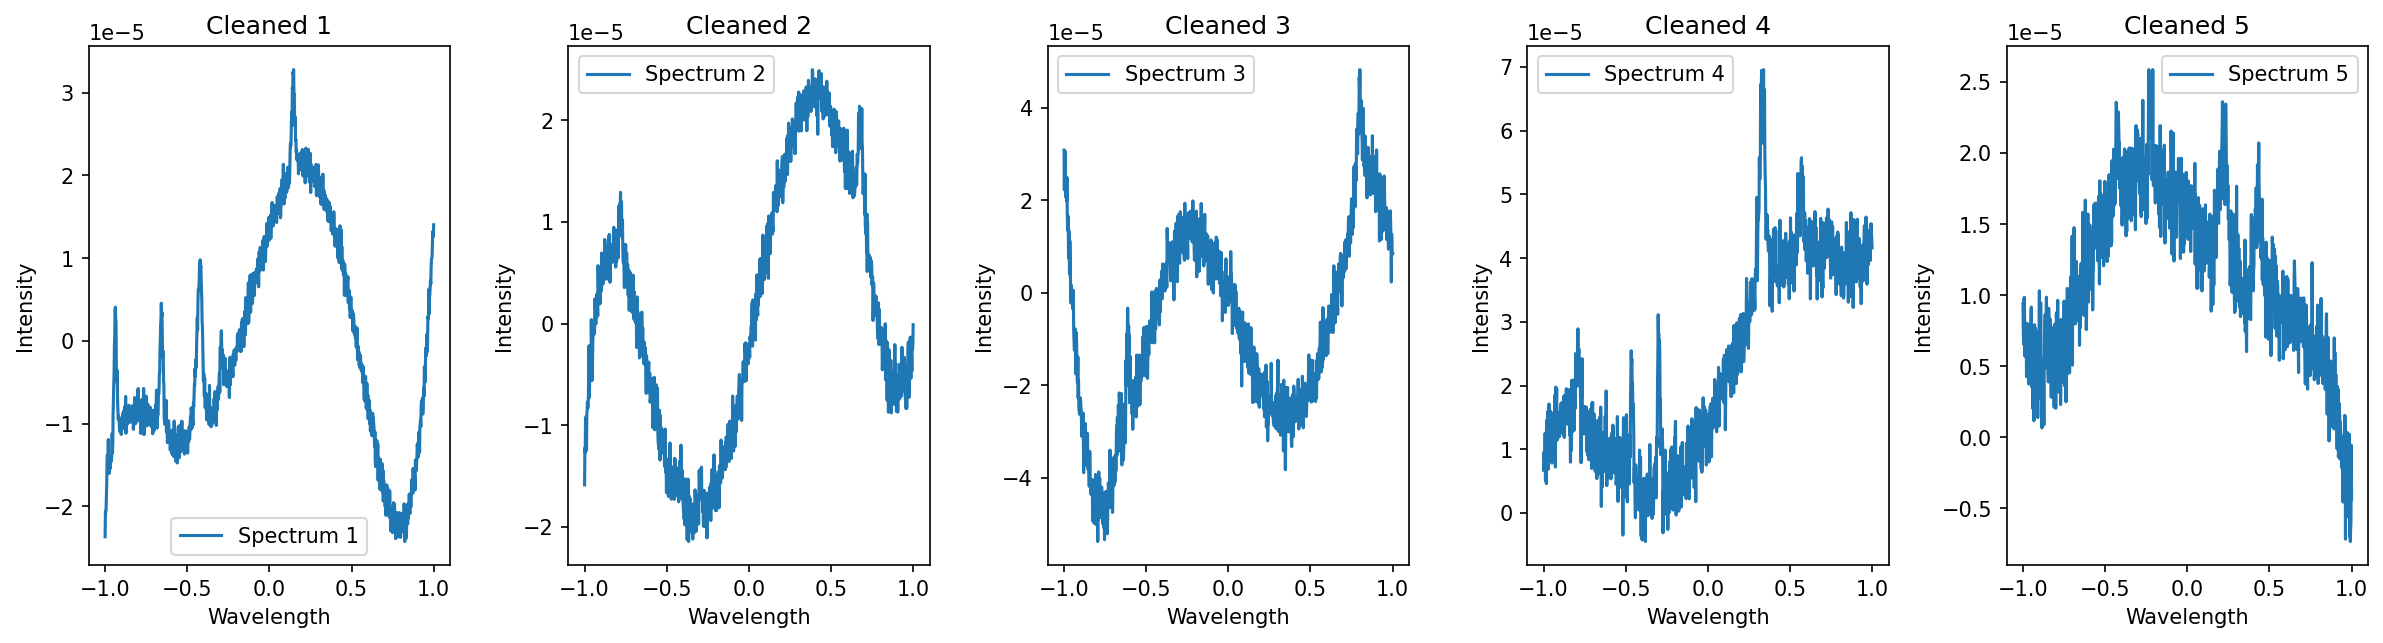

In [3]:
# CLEAN RAYS
# THRESHOLD VALUE (2.0)
# Replace points by LINEAR INTERPOLATION
# ILOC method
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if spectrum exists in the data
    if not spectrum_data.empty:
        full_spectrum_intensity = spectrum_data[spectrum_data['Intensity_Type'] == 'Full_Spectrum']['Intensity']
        
        # Normalize spectrum before cleaning
        full_spectrum_intensity /= full_spectrum_intensity.max()

        # 1) Calculate second difference of spectrum to accentuate sharp spikes
        first_difference = np.diff(full_spectrum_intensity, n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum_intensity)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")

            # 3) Replace these points using linear interpolation from neighboring data points
            for index in cosmic_ray_indices:
                if 0 <= index - 1 < len(full_spectrum_intensity) and 0 <= index + 1 < len(full_spectrum_intensity):
                    left_neighbor = full_spectrum_intensity.iloc[index - 1]
                    right_neighbor = full_spectrum_intensity.iloc[index + 1]

                    # Linear interpolation to replace cosmic ray spike
                    interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                    spectrum_data.iloc[full_spectrum_intensity.index[index], 'Intensity'] = interpolated_value
        
        # Normalize spectrum after cleaning
        spectrum_data['Intensity'] /= spectrum_data['Intensity'].max()

        # Drop duplicate entries in 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append cleaned spectrum to list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Calculate the number of plots based on the number of synthetic spectra or cleaned spectra
num_plots = min(len(synthetic_data_generator.full_spectra_list), len(cleaned_spectra))

# Plot high resolution
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Original {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(16, 8), dpi=150)
for i, spectrum_data in enumerate(cleaned_spectra[:num_plots]):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()

No cosmic rays detected in Spectrum_1: 0 points
No cosmic rays detected in Spectrum_2: 0 points
No cosmic rays detected in Spectrum_3: 0 points
No cosmic rays detected in Spectrum_4: 0 points
No cosmic rays detected in Spectrum_5: 0 points


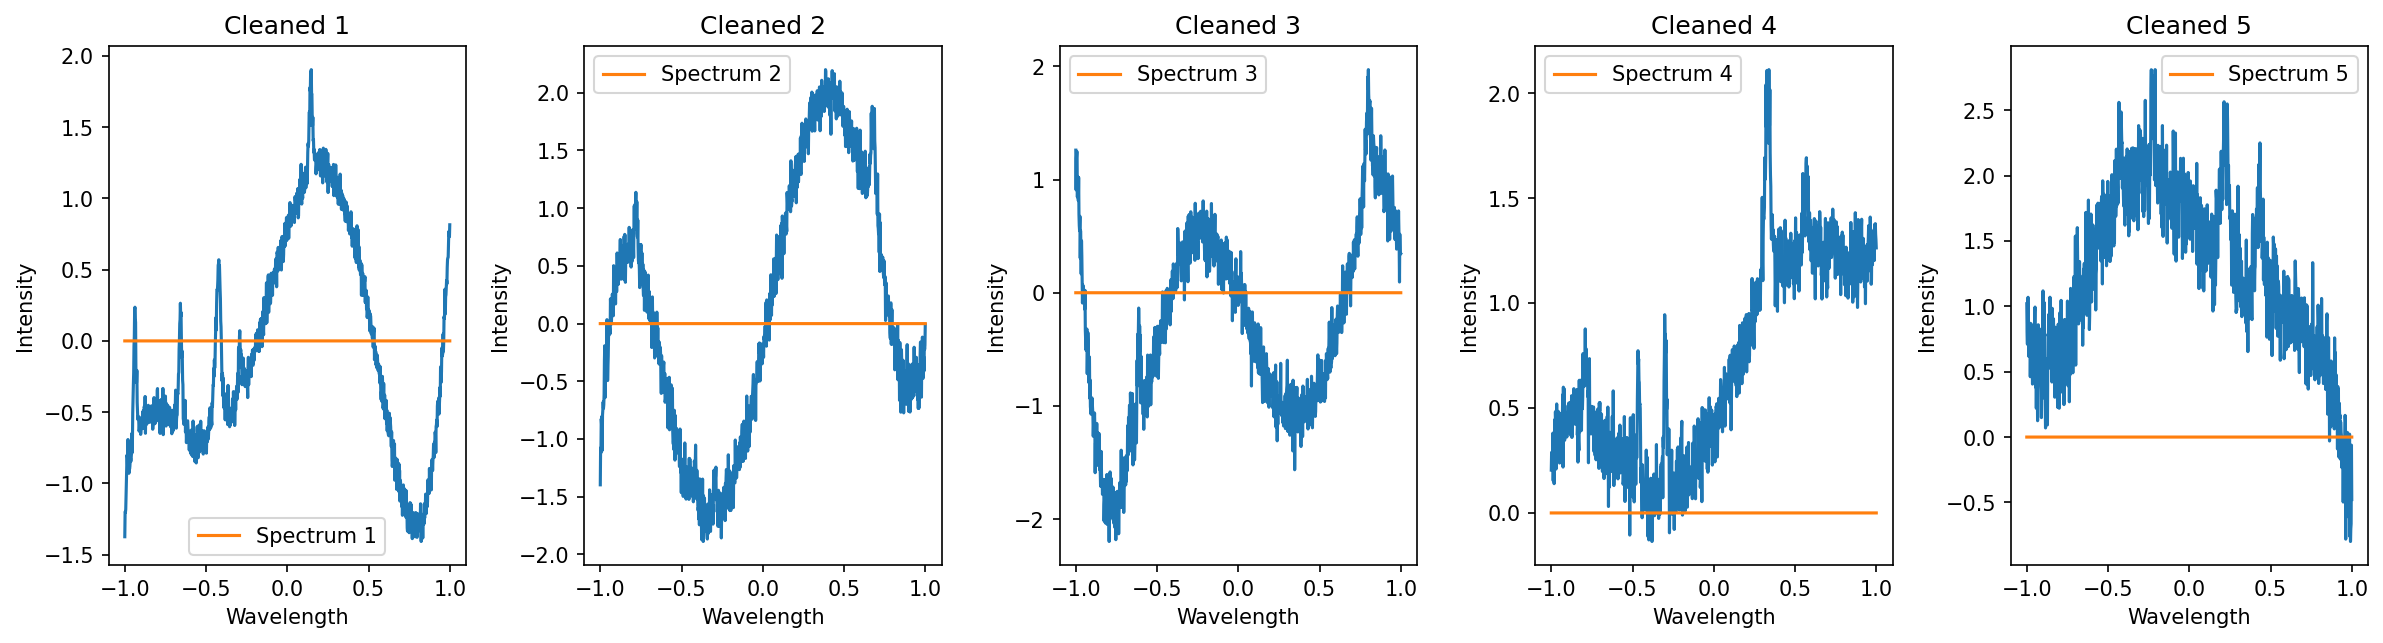

In [4]:
#PART 2:  working directly with original DataFrame data to modify intensity values

# CLEAN RAYS
# THRESHOLD VALUE (2.0)
# Replace points by LINEAR INTERPOLATION
# ILOC method
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id].copy()  # Make a copy to avoid modifying the original DataFrame

    # Check if spectrum exists in the data
    if not spectrum_data.empty:
        full_spectrum_intensity = spectrum_data[spectrum_data['Intensity_Type'] == 'Full_Spectrum']['Intensity']

        # Normalize spectrum before cleaning
        full_spectrum_intensity /= full_spectrum_intensity.max()

        # 1) Calculate second difference of spectrum to accentuate sharp spikes
        first_difference = np.diff(full_spectrum_intensity, n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum_intensity)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")

            # 3) Replace these points using linear interpolation from neighboring data points
            for index in cosmic_ray_indices:
                if 0 <= index - 1 < len(full_spectrum_intensity) and 0 <= index + 1 < len(full_spectrum_intensity):
                    left_neighbor = full_spectrum_intensity.iloc[index - 1]
                    right_neighbor = full_spectrum_intensity.iloc[index + 1]

                    # Linear interpolation to replace cosmic ray spike
                    interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                    spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

            # Normalize spectrum after cleaning
            cleaned_intensity = spectrum_data['Intensity'] / spectrum_data['Intensity'].max()

            # Drop duplicate entries in 'Wavelength' column
            spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

            # Append cleaned spectrum to list
            cleaned_spectrum = spectrum_data.assign(Intensity=cleaned_intensity)
            cleaned_spectra.append(cleaned_spectrum)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Calculate the number of plots based on the number of synthetic spectra or cleaned spectra
num_plots = min(len(synthetic_data_generator.full_spectra_list), len(cleaned_spectra))

# Plot high resolution
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Original {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
for i in range(num_plots):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data_cleaned = data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]

    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data_cleaned['Wavelength'], spectrum_data_cleaned['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()


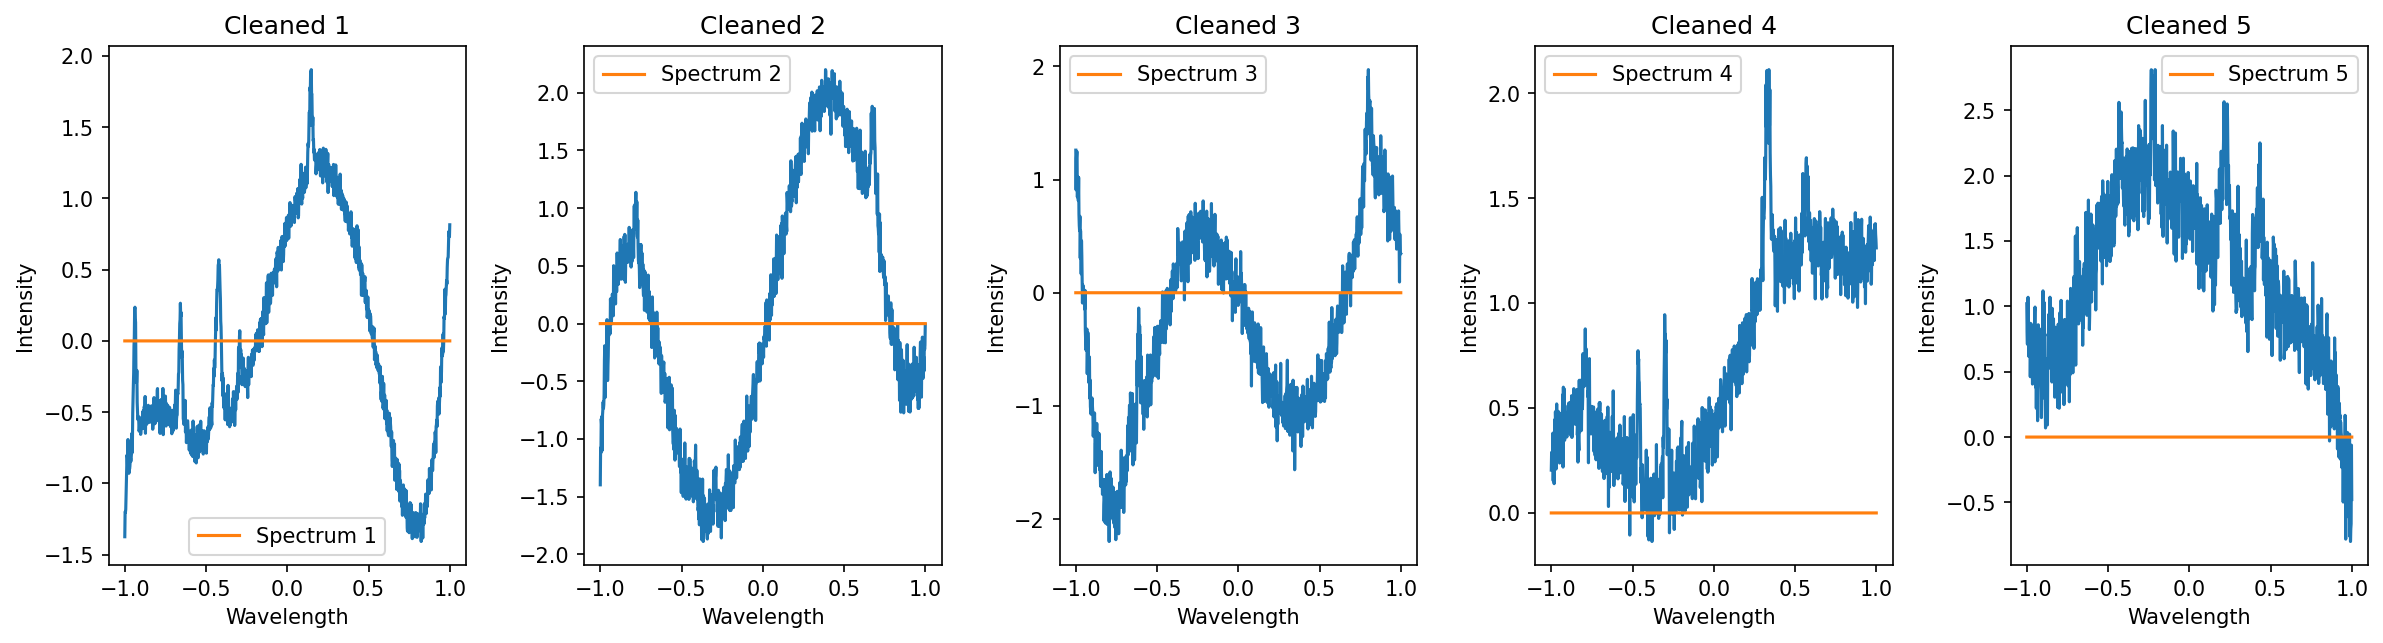

In [5]:
# Calculate the number of plots based on the number of synthetic spectra or cleaned spectra
num_plots = min(len(synthetic_data_generator.full_spectra_list), len(cleaned_spectra))

# Plot high resolution
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Original {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
for i in range(num_plots):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data_cleaned = data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]

    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data_cleaned['Wavelength'], spectrum_data_cleaned['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()

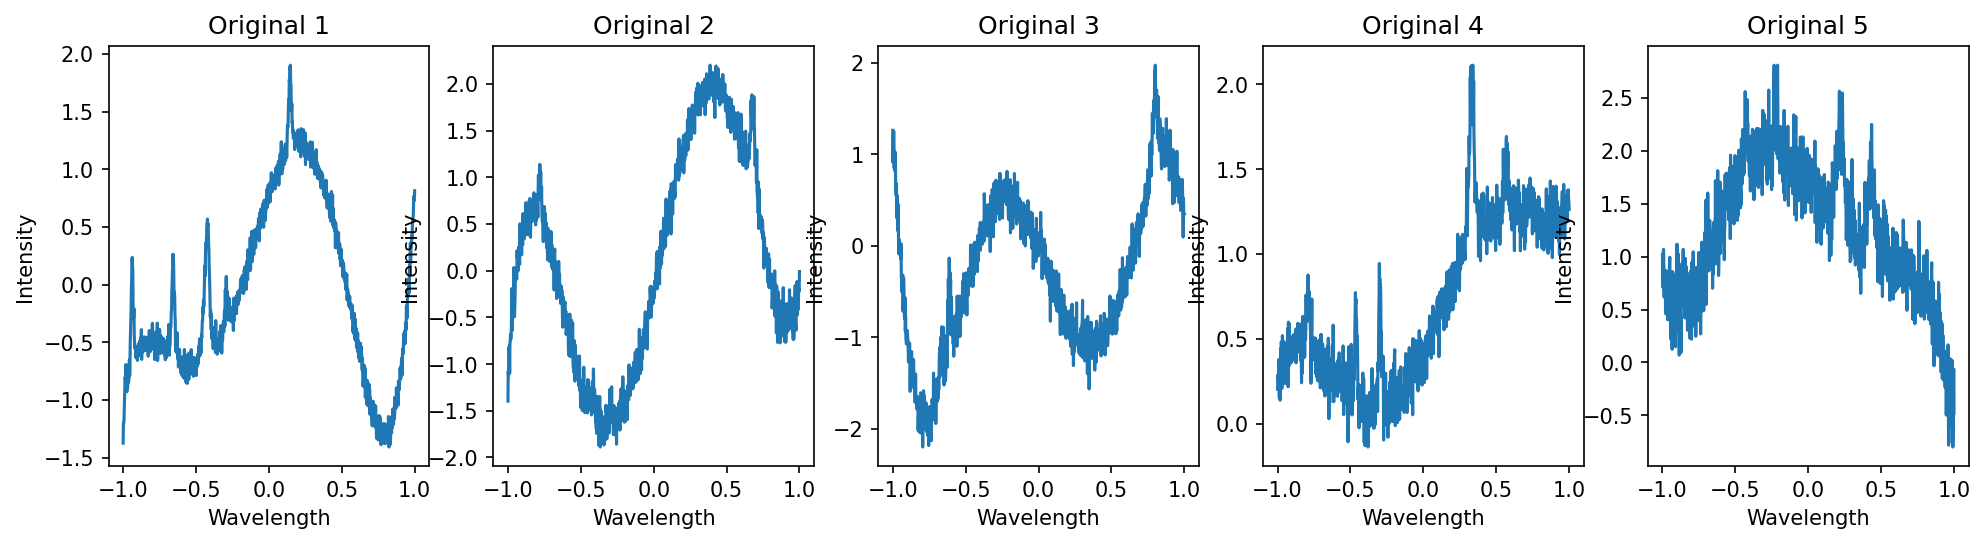

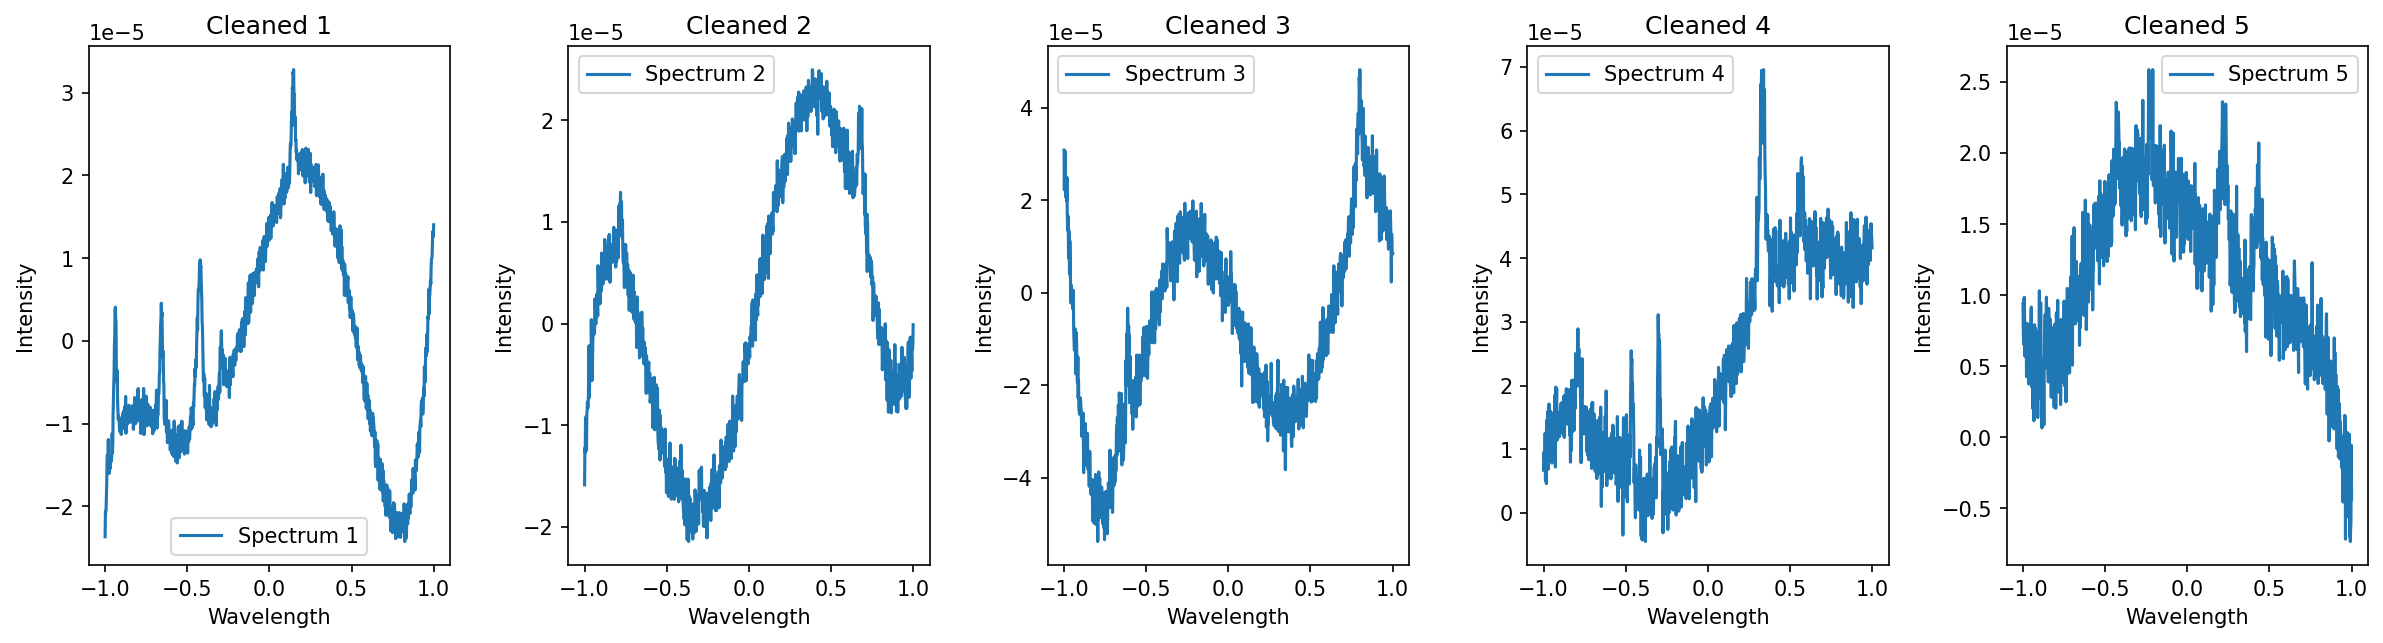

In [6]:
# Plot high resolution
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Original {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Create a new figure for cleaned spectra
plt.figure(figsize=(16, 8), dpi=150)

# Plot cleaned spectra
for i in range(num_plots):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data_cleaned = data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]

    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data_cleaned['Wavelength'], spectrum_data_cleaned['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()


No cosmic rays detected in Spectrum_1: 1024 points
Cosmic rays detected in Spectrum_1
No cosmic rays detected in Spectrum_2: 1024 points
Cosmic rays detected in Spectrum_2
No cosmic rays detected in Spectrum_3: 1024 points
Cosmic rays detected in Spectrum_3
No cosmic rays detected in Spectrum_4: 1024 points
Cosmic rays detected in Spectrum_4
No cosmic rays detected in Spectrum_5: 1024 points
Cosmic rays detected in Spectrum_5
  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   1.560905
1  Spectrum_1   -0.998045  Full_Spectrum   1.539693
2  Spectrum_1   -0.996090  Full_Spectrum   1.410573
3  Spectrum_1   -0.994135  Full_Spectrum   1.699345
4  Spectrum_1   -0.992180  Full_Spectrum   1.458401


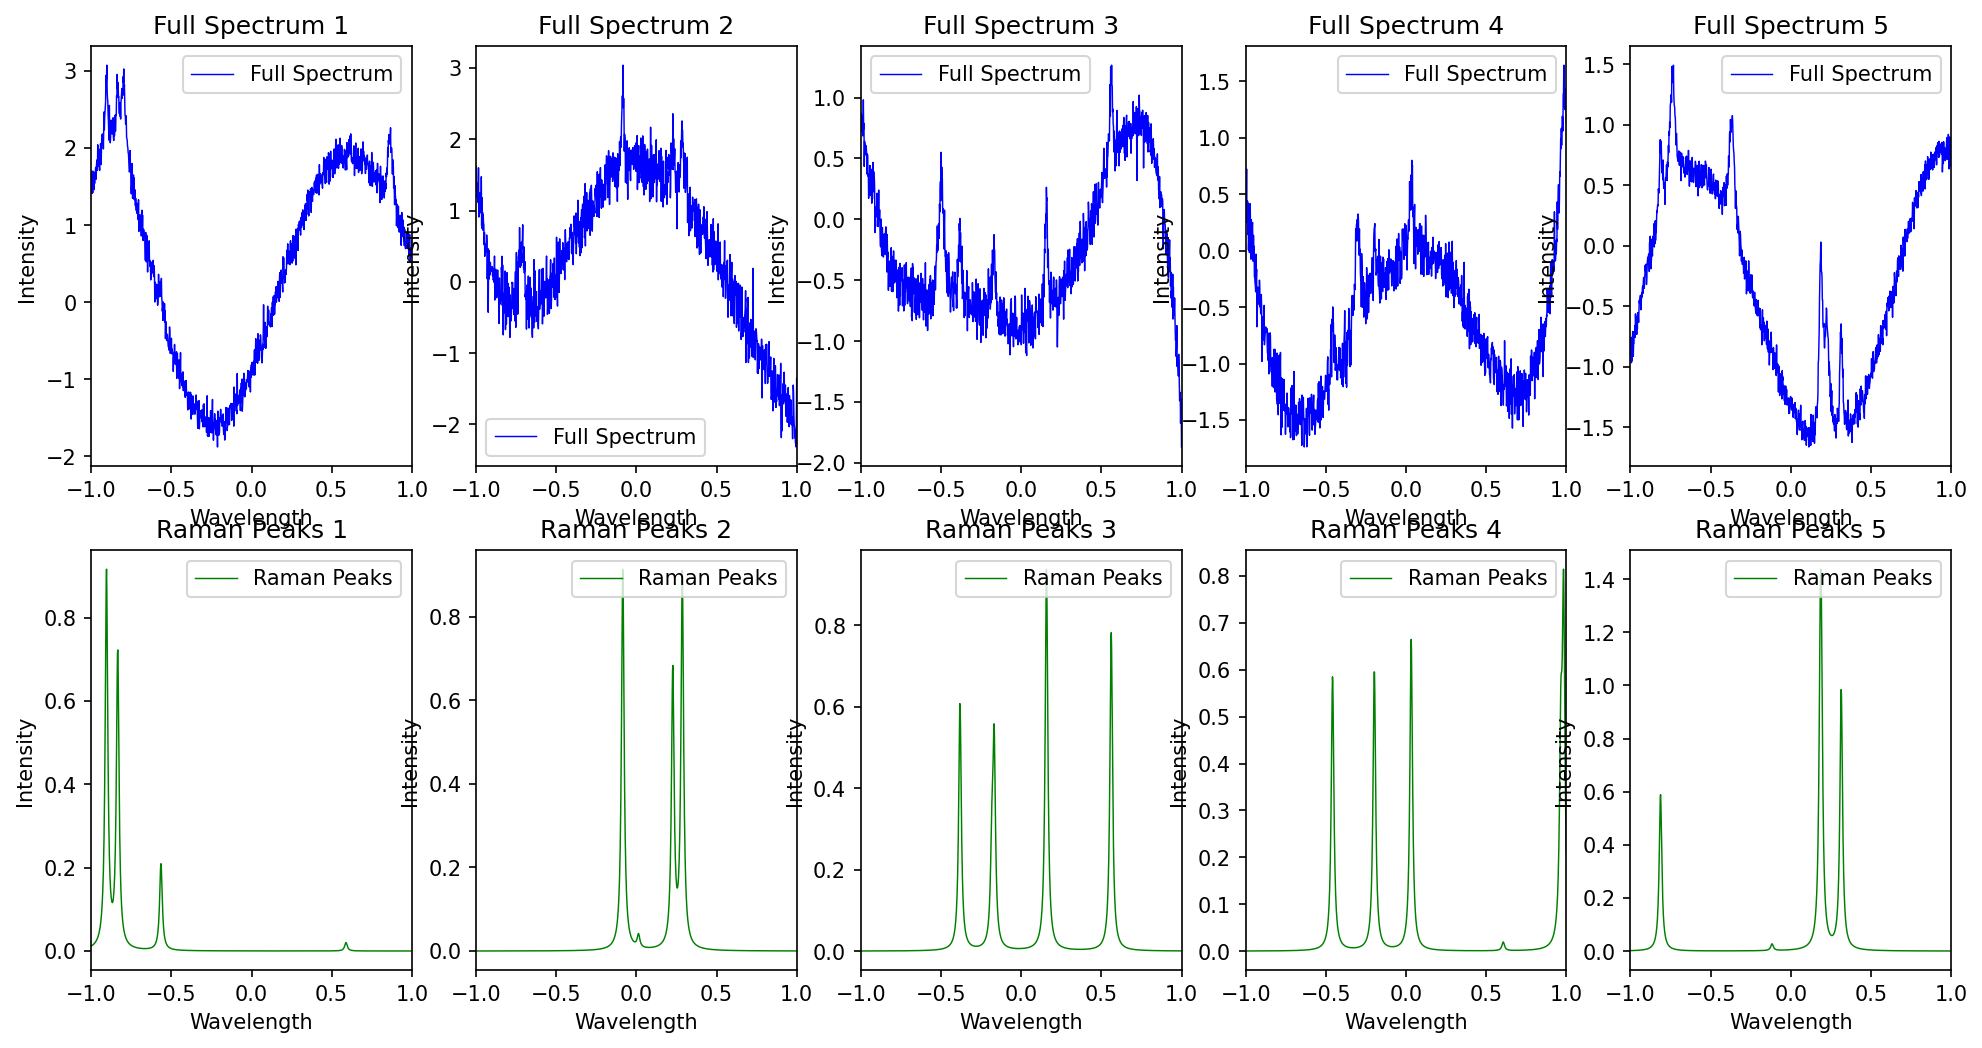

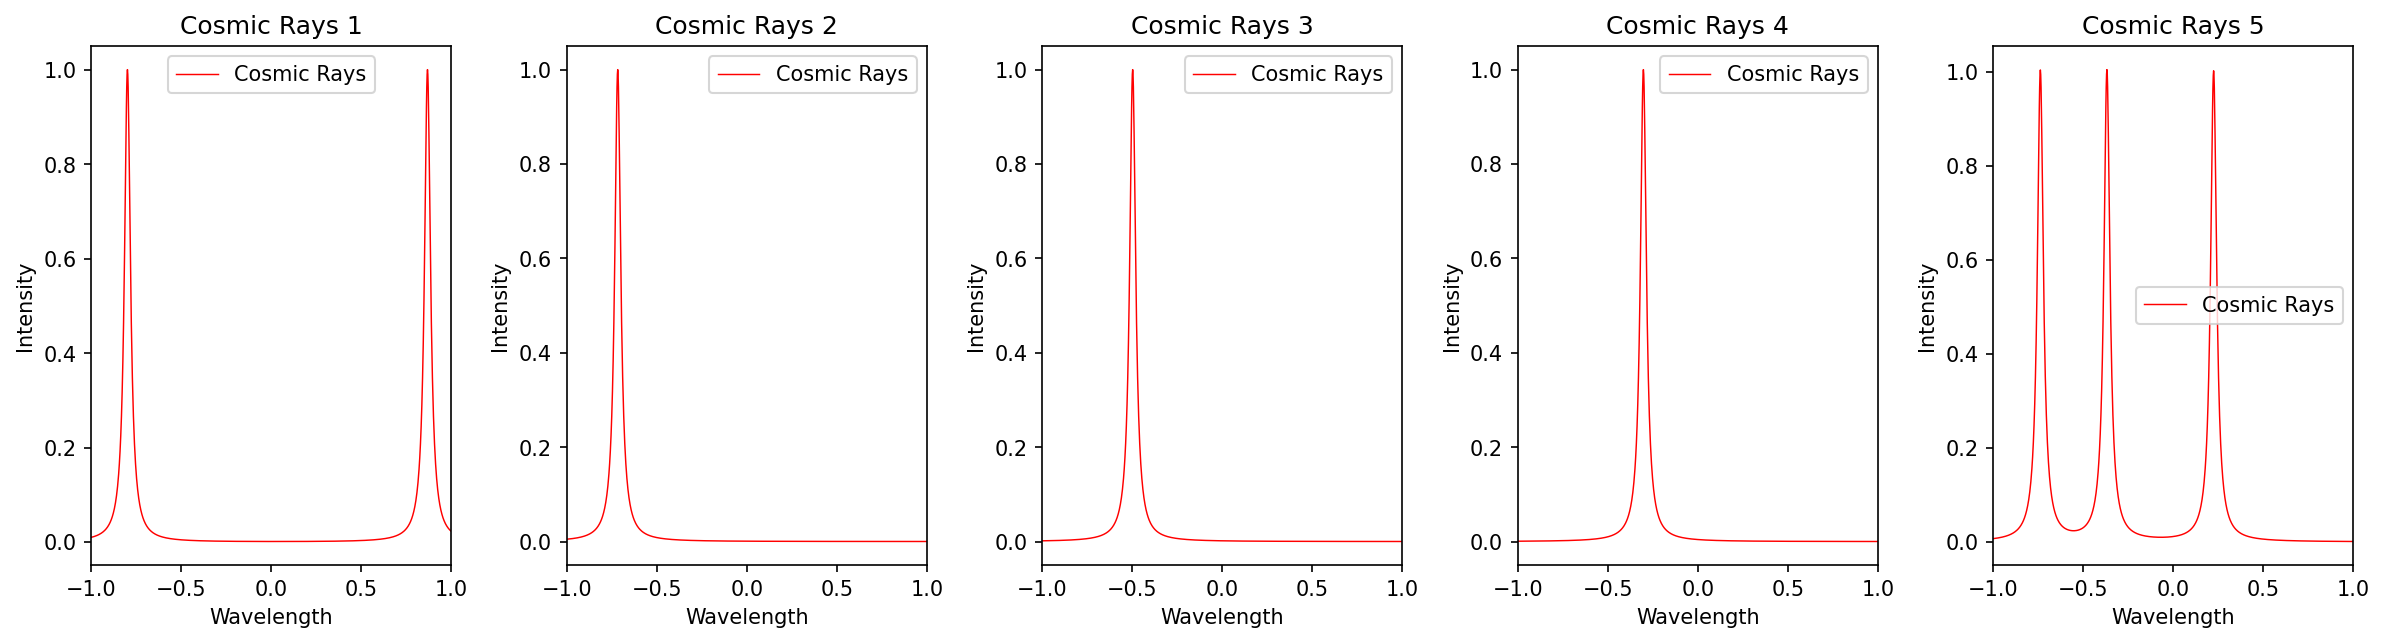

In [7]:
# SYNTHETIC SPECTRA 'ADDING CORRECTLY COSMIC RAYS'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []
        self.cosmic_rays_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self):
        cosmic_rays_spectrum = np.zeros_like(self.wavelengths)

        # Generate a random number of cosmic rays between 1 and 3
        num_cosmic_rays = np.random.randint(1, 4)

        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, np.linalg.norm(self.noisy_peaky_cheby))

            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))

            # Create cosmic ray using Lorentzian peak
            width_factor = 0.02
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2 + width_factor ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to separate array
            cosmic_rays_spectrum += cosmic_ray

        # Add rays to noise peaky cheby spectra
        self.noisy_peaky_cheby_rays = self.noisy_peaky_cheby + cosmic_rays_spectrum

        # Update Full Synthetic Spectrum
        full_spectrum = self.noisy_peaky_cheby_rays
        self.full_spectra_list.append(full_spectrum)

        # Update Raman Spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

        # Update Cosmic Rays
        self.cosmic_rays_list.append(cosmic_rays_spectrum)

        # Print information about detected cosmic rays
        cosmic_ray_indices = np.where(cosmic_rays_spectrum > 0)[0]
        spectrum_id = f'Spectrum_{len(self.full_spectra_list)}'

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        
        # Check if cosmic rays are present in the spectrum
        if any(cosmic_rays_spectrum > 0):
            print(f"Cosmic rays detected in {spectrum_id}")
        else:
            print(f"No cosmic rays detected in {spectrum_id}")

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum, cosmic_rays) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list, self.cosmic_rays_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, cosmic_rays)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Cosmic_Rays',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df
    
# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    synthetic_data_generator.add_cosmic_rays()

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Plot high resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot original spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', linewidth=0.7, label='Full Spectrum')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
    
# Plot Raman peaks
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7, label='Raman Peaks')
    plt.title(f'Raman Peaks {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()

# Plot cosmic rays only
plt.figure(figsize=(16, 8), dpi=150)
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.cosmic_rays_list[i], color='red', linewidth=0.7, label='Cosmic Rays')
    plt.title(f'Cosmic Rays {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
     
# Show plots
plt.tight_layout()
plt.show()

No cosmic rays detected in Spectrum_1: 0 points
No cosmic rays detected in Spectrum_2: 0 points
No cosmic rays detected in Spectrum_3: 0 points
No cosmic rays detected in Spectrum_4: 0 points
No cosmic rays detected in Spectrum_5: 0 points


/tmp/ipykernel_18/121909138.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrum_data['Intensity'] /= spectrum_data['Intensity'].max()


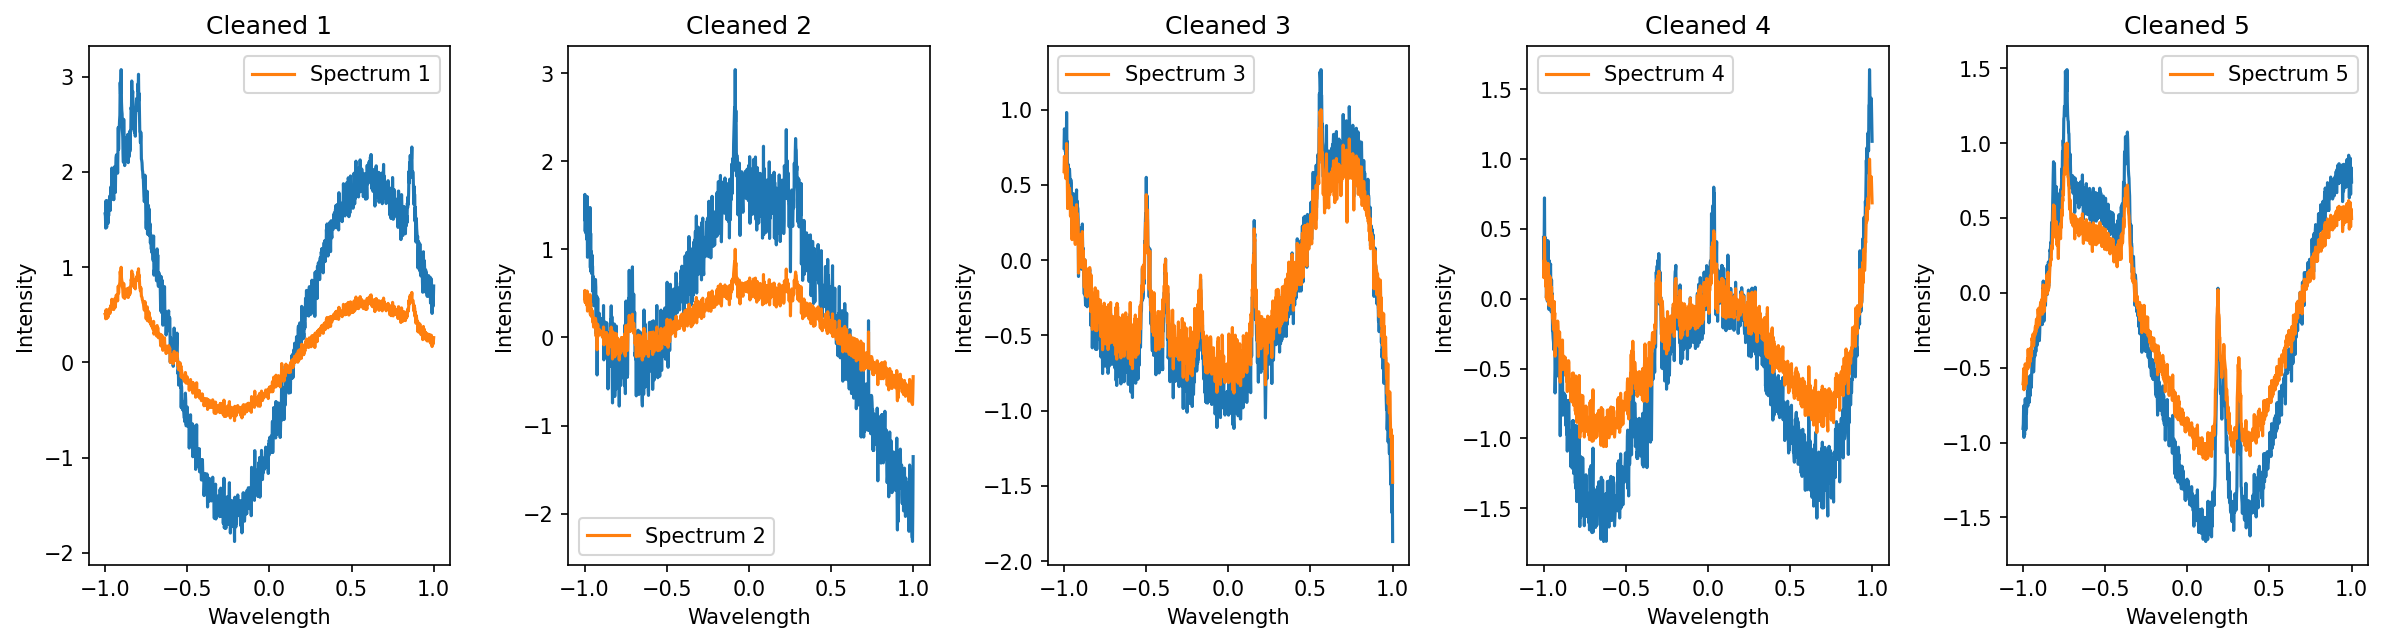

In [8]:
# CLEAN RAYS
# THRESHOLD VALUE (2.0)
# Replace points by LINEAR INTERPOLATION
# ILOC method
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if spectrum exists in the data
    if not spectrum_data.empty:
        full_spectrum_intensity = spectrum_data[spectrum_data['Intensity_Type'] == 'Full_Spectrum']['Intensity']
        
        # Normalize spectrum before cleaning
        full_spectrum_intensity /= full_spectrum_intensity.max()

        # 1) Calculate second difference of spectrum to accentuate sharp spikes
        first_difference = np.diff(full_spectrum_intensity, n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum_intensity)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")

            # 3) Replace these points using linear interpolation from neighboring data points
            for index in cosmic_ray_indices:
                if 0 <= index - 1 < len(full_spectrum_intensity) and 0 <= index + 1 < len(full_spectrum_intensity):
                    left_neighbor = full_spectrum_intensity.iloc[index - 1]
                    right_neighbor = full_spectrum_intensity.iloc[index + 1]

                    # Linear interpolation to replace cosmic ray spike
                    interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                    spectrum_data.iloc[full_spectrum_intensity.index[index], 'Intensity'] = interpolated_value
        
        # Normalize spectrum after cleaning
        spectrum_data['Intensity'] /= spectrum_data['Intensity'].max()

        # Drop duplicate entries in 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append cleaned spectrum to list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Calculate the number of plots based on the number of synthetic spectra or cleaned spectra
num_plots = min(len(synthetic_data_generator.full_spectra_list), len(cleaned_spectra))

# Plot high resolution
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Original {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
for i, spectrum_data in enumerate(cleaned_spectra[:num_plots]):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # adjust layout (prevent overlapping)
plt.show()